-----
<center>
<h1 style="font-size: 50px; font-family: serif;">Cardiac Conduction Simulation: A Hybrid Deep Learning Approach to Classify Realistic ECG Signals
</h1>
</center>

---

<center>
<img src="giphy.webp" width="550" height='100'>
</center>


---
# 1. Import Modules 
<span id="Importmodules"></span>

---

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
import os
import warnings
warnings.filterwarnings("ignore")

In [40]:
# Load and preprocess the dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

In [44]:
# ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

---
# 2. Load images with augmentation
<span id="Importmodules"></span>

---

In [19]:
# Load images from the training directory
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load images from the testing directory
test_data_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")

Found 928 images belonging to 4 classes.
Found 448 images belonging to 4 classes.
1/1 [==============================] - 1s 577ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [7]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  

input_shape = X_train_features.shape[1]  # The number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/100
24/24 [==============================] - 1s 31ms/step - loss: 1.6681 - accuracy: 0.3598 - val_loss: 0.9873 - val_accuracy: 0.5753
Epoch 2/100
24/24 [==============================] - 1s 24ms/step - loss: 1.3520 - accuracy: 0.4609 - val_loss: 0.8934 - val_accuracy: 0.6075
Epoch 3/100
24/24 [==============================] - 1s 24ms/step - loss: 1.1125 - accuracy: 0.4973 - val_loss: 0.8767 - val_accuracy: 0.6075
Epoch 4/100
24/24 [==============================] - 1s 23ms/step - loss: 1.0798 - accuracy: 0.5714 - val_loss: 0.8261 - val_accuracy: 0.6989
Epoch 5/100
24/24 [==============================] - 1s 23ms/step - loss: 0.9956 - accuracy: 0.5755 - val_loss: 0.8008 - val_accuracy: 0.6559
Epoch 6/100
24/24 [==============================] - 1s 23ms/step - loss: 0.9905 - accuracy: 0.6078 - val_loss: 0.7656 - val_accuracy: 0.7043
Epoch 7/100
24/24 [==============================] - 1s 25ms/step - loss: 0.9022 - accuracy: 0.6253 - val_loss: 0.7451 - val_accuracy: 0.6935
Epoch 

In [8]:
# Save the trained model
model.save('mobilenet_v2_classifier_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

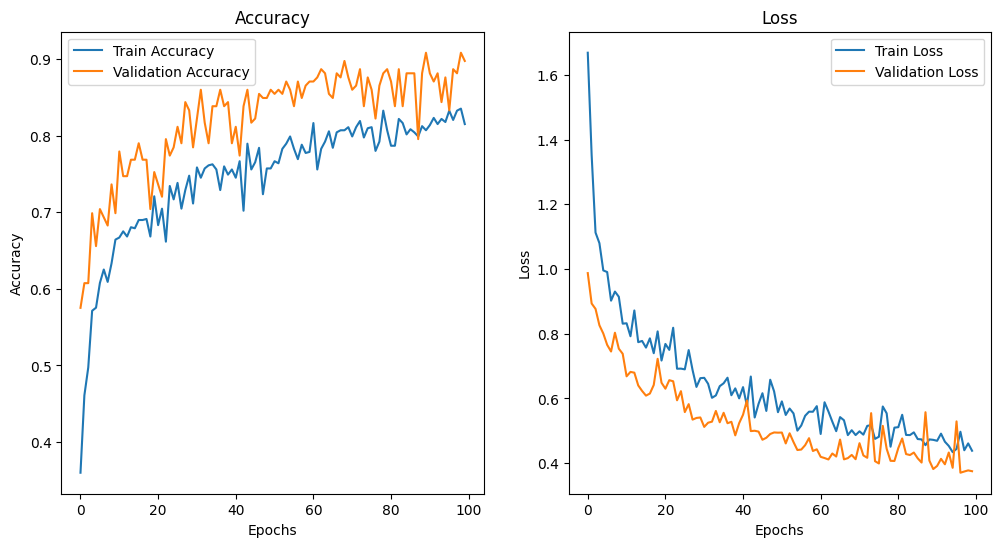

In [9]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

14/14 [==============================] - 0s 4ms/step - loss: 0.2475 - accuracy: 0.9286
Test accuracy: 0.9286
Test loss: 0.2475
14/14 [==============================] - 0s 3ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[112   0   0   0]
 [  0  89   6  17]
 [  0   2 107   3]
 [  2   2   0 108]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       112
           1       0.96      0.79      0.87       112
           2       0.95      0.96      0.95       112
           3       0.84      0.96      0.90       112

    accuracy                           0.93       448
   macro avg       0.93      0.93      0.93       448
weighted avg       0.93      0.93      0.93       448



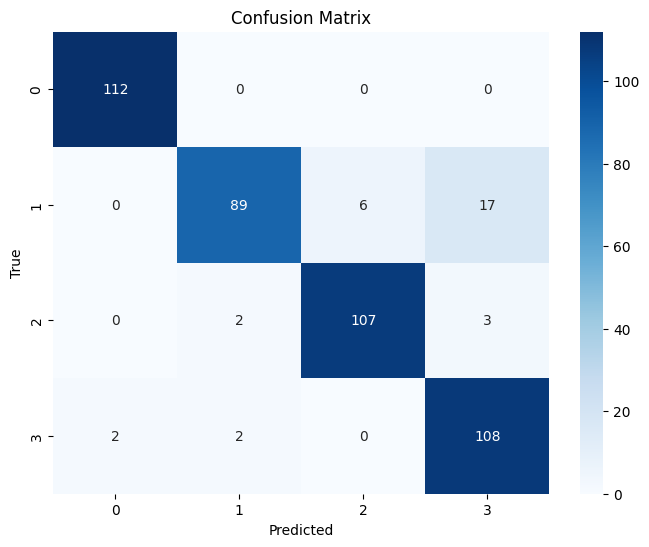

In [11]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 6. Densenet Model
<span id="Importmodules"></span>

---

In [13]:
# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dense(512, activation='relu')(input_layer)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(256, activation='relu')(x)  # Another fully connected layer
x = Dropout(0.5)(x)  # Dropout layer
x = Dense(128, activation='relu')(x)  # Another fully connected layer
x = Dropout(0.5)(x)  # Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val))

Epoch 1/100
24/24 [==============================] - 2s 28ms/step - loss: 1.6143 - accuracy: 0.2911 - val_loss: 1.3012 - val_accuracy: 0.3602
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 1.4270 - accuracy: 0.3221 - val_loss: 1.2741 - val_accuracy: 0.4946
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 1.3406 - accuracy: 0.3571 - val_loss: 1.2097 - val_accuracy: 0.5215
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 1.2404 - accuracy: 0.4218 - val_loss: 1.0936 - val_accuracy: 0.5645
Epoch 5/100
24/24 [==============================] - 1s 25ms/step - loss: 1.1452 - accuracy: 0.4960 - val_loss: 1.0183 - val_accuracy: 0.5591
Epoch 6/100
24/24 [==============================] - 1s 22ms/step - loss: 1.1297 - accuracy: 0.4852 - val_loss: 0.9942 - val_accuracy: 0.5806
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 1.1034 - accuracy: 0.5094 - val_loss: 0.9996 - val_accuracy: 0.5753
Epoch 

In [14]:
# Save the trained model
model.save('dense_classifier_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
# 7. Plot training and validation accuracy
<span id="Importmodules"></span>

---

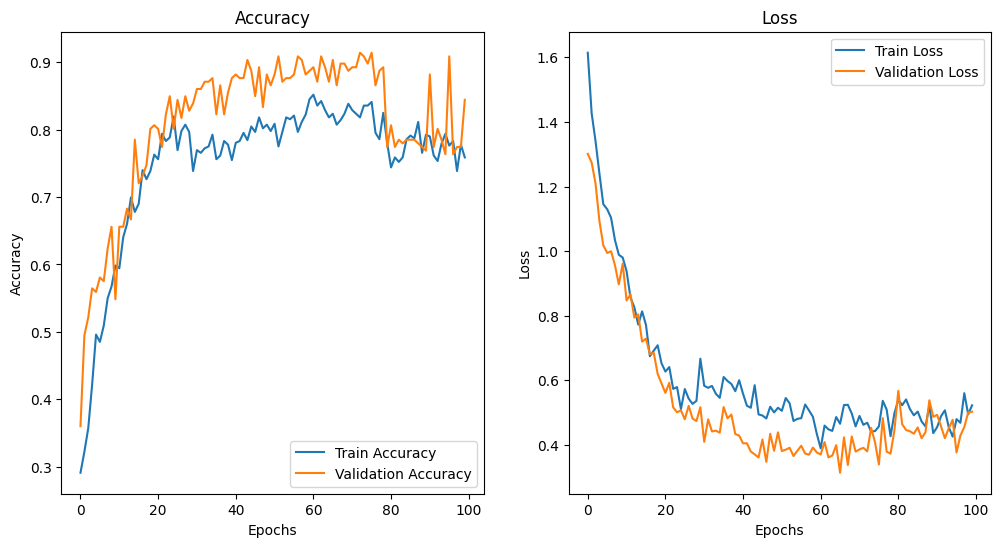

In [15]:

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

14/14 [==============================] - 0s 3ms/step - loss: 0.3192 - accuracy: 0.9152
Test accuracy: 0.9152
Test loss: 0.3192


---
# 8. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

14/14 [==============================] - 0s 2ms/step
Confusion Matrix:
[[112   0   0   0]
 [  0  88  14  10]
 [  0   4 107   1]
 [  1   8   0 103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       112
           1       0.88      0.79      0.83       112
           2       0.88      0.96      0.92       112
           3       0.90      0.92      0.91       112

    accuracy                           0.92       448
   macro avg       0.91      0.92      0.91       448
weighted avg       0.91      0.92      0.91       448



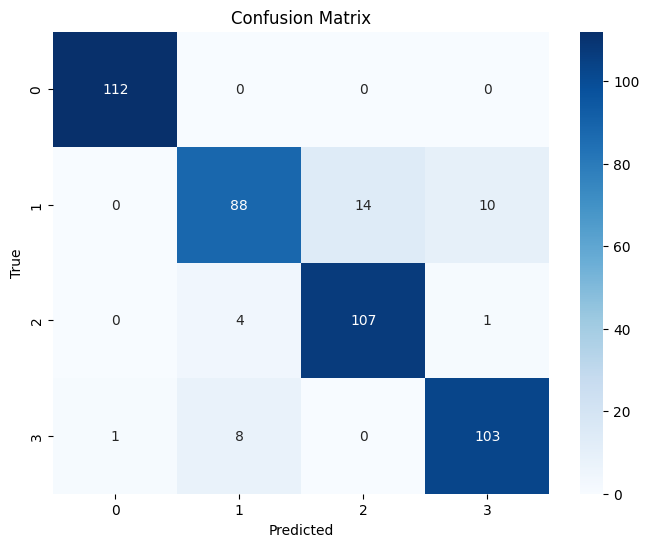

In [17]:

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 10. CNN Model
<span id="Importmodules"></span>

---

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load the features and labels for train, validation, and test sets
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Print the shape of the features to confirm
print(f"X_train_features shape: {X_train_features.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}")
print(f"X_test_features shape: {X_test_features.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}")

# Define the fully connected model for the extracted features
model = Sequential()

# Input layer (feature vectors of size 1024)
model.add(Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Hidden layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(y_train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val))

X_train_features shape: (742, 1024)
y_train_labels shape: (742, 4)
X_test_features shape: (448, 1024)
y_test_labels shape: (448, 4)
Epoch 1/50
24/24 [==============================] - 3s 70ms/step - loss: 1.6713 - accuracy: 0.3059 - val_loss: 1.2119 - val_accuracy: 0.5108
Epoch 2/50
24/24 [==============================] - 1s 53ms/step - loss: 1.3717 - accuracy: 0.3585 - val_loss: 1.1283 - val_accuracy: 0.5591
Epoch 3/50
24/24 [==============================] - 2s 73ms/step - loss: 1.2548 - accuracy: 0.4043 - val_loss: 1.0479 - val_accuracy: 0.5538
Epoch 4/50
24/24 [==============================] - 2s 81ms/step - loss: 1.1178 - accuracy: 0.4933 - val_loss: 0.9506 - val_accuracy: 0.5968
Epoch 5/50
24/24 [==============================] - 2s 68ms/step - loss: 1.0668 - accuracy: 0.5000 - val_loss: 0.9614 - val_accuracy: 0.5753
Epoch 6/50
24/24 [==============================] - 2s 68ms/step - loss: 0.9841 - accuracy: 0.5836 - val_loss: 0.8992 - val_accuracy: 0.6290
Epoch 7/50
24/24 [====

In [26]:
# Save the model
model.save('cnn_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

14/14 [==============================] - 0s 5ms/step - loss: 0.3094 - accuracy: 0.8951
Test accuracy: 0.8951
Test loss: 0.3094


---
# 11. Plot training and validation accuracy
<span id="Importmodules"></span>

---

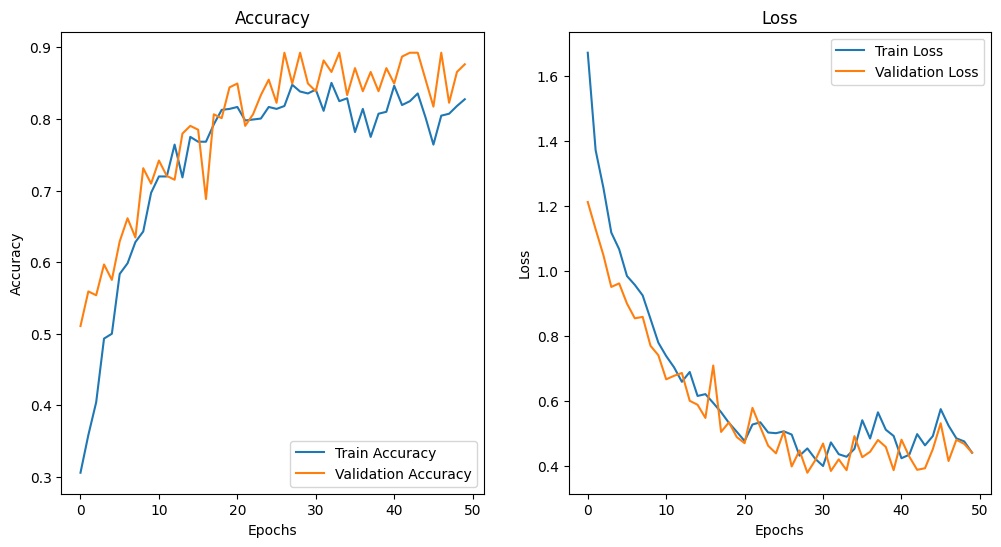

In [28]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 12. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

14/14 [==============================] - 0s 4ms/step
Confusion Matrix:
[[112   0   0   0]
 [  0  71  10  31]
 [  0   1 108   3]
 [  2   0   0 110]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       112
           1       0.99      0.63      0.77       112
           2       0.92      0.96      0.94       112
           3       0.76      0.98      0.86       112

    accuracy                           0.90       448
   macro avg       0.91      0.90      0.89       448
weighted avg       0.91      0.90      0.89       448



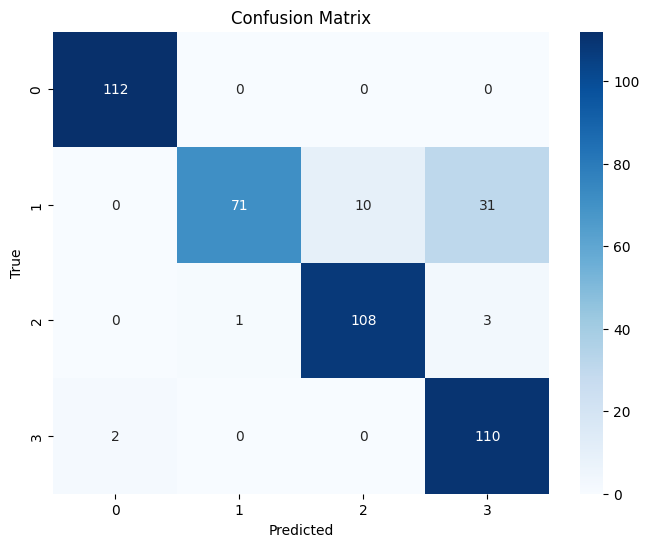

In [29]:
# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 13. Hybrid Model(MobileNet and LSTM)
<span id="Importmodules"></span>

---

In [31]:
import numpy as np
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load your pre-extracted features and labels
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Check the shapes of the features
print(f"X_train_features shape: {X_train_features.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}")
print(f"X_test_features shape: {X_test_features.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}")

# Reshape the features for LSTM input
# LSTM expects input shape: (batch_size, time_steps, features)
# We will treat the 1024 features as "time steps" for each sequence.

# Reshape X_train_features and X_test_features into sequences
time_steps = 32  # You can adjust this based on how you want to structure your sequences
input_features = X_train_features.shape[1]  # This is 1024, which is the feature size from MobileNetV2

# Reshape the feature vectors into sequences
X_train_reshaped = X_train_features.reshape((-1, time_steps, input_features // time_steps))
X_val_reshaped = X_val.reshape((-1, time_steps, input_features // time_steps))
X_test_reshaped = X_test_features.reshape((-1, time_steps, input_features // time_steps))

print(f"Reshaped X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"Reshaped X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"Reshaped X_test_reshaped shape: {X_test_reshaped.shape}")

# Define the LSTM model architecture
model = Sequential()

# LSTM layer - process the sequential data
model.add(LSTM(256, return_sequences=False, input_shape=(time_steps, input_features // time_steps)))

# Dropout layer for regularization
model.add(Dropout(0.5))

# Dense layer for classification
model.add(Dense(128, activation='relu'))

# Output layer with softmax activation (for multi-class classification)
model.add(Dense(y_train_labels.shape[1], activation='softmax'))  # Number of classes is 4

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_labels, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val_reshaped, y_val))



X_train_features shape: (742, 1024)
y_train_labels shape: (742, 4)
X_test_features shape: (448, 1024)
y_test_labels shape: (448, 4)
Reshaped X_train_reshaped shape: (742, 32, 32)
Reshaped X_val_reshaped shape: (186, 32, 32)
Reshaped X_test_reshaped shape: (448, 32, 32)
Epoch 1/50
24/24 [==============================] - 4s 64ms/step - loss: 1.3450 - accuracy: 0.3302 - val_loss: 1.2267 - val_accuracy: 0.4892
Epoch 2/50
24/24 [==============================] - 1s 51ms/step - loss: 1.2515 - accuracy: 0.4111 - val_loss: 1.0750 - val_accuracy: 0.5269
Epoch 3/50
24/24 [==============================] - 1s 52ms/step - loss: 1.1231 - accuracy: 0.4960 - val_loss: 1.0464 - val_accuracy: 0.5538
Epoch 4/50
24/24 [==============================] - 1s 44ms/step - loss: 1.0520 - accuracy: 0.5121 - val_loss: 1.0146 - val_accuracy: 0.5430
Epoch 5/50
24/24 [==============================] - 2s 66ms/step - loss: 0.9968 - accuracy: 0.5458 - val_loss: 1.0041 - val_accuracy: 0.5323
Epoch 6/50
24/24 [=======

In [32]:
# Save the model
model.save('mobilenet_lstm_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

14/14 [==============================] - 0s 17ms/step - loss: 0.1996 - accuracy: 0.9397
Test accuracy: 0.9397
Test loss: 0.1996


---
# 14. Plot training and validation accuracy
<span id="Importmodules"></span>

---

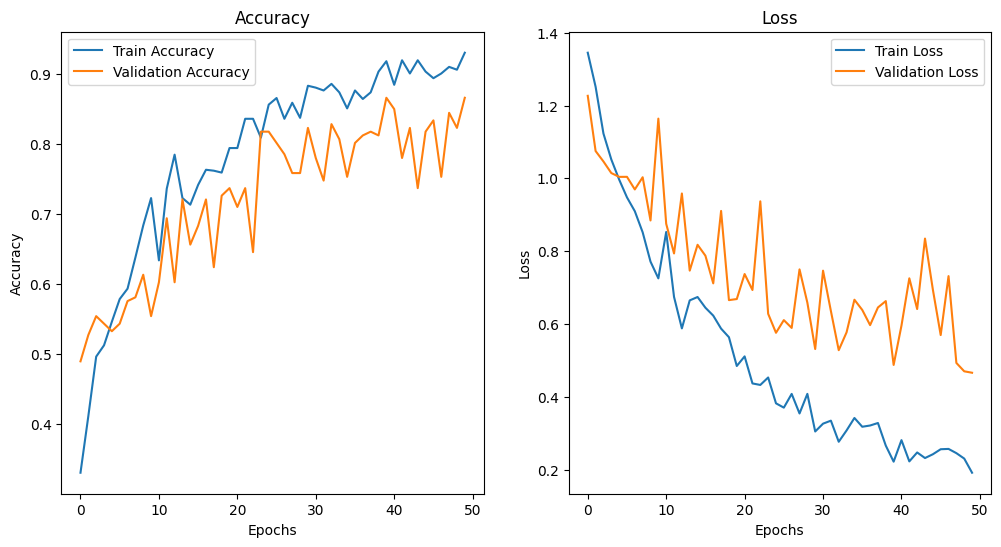

In [34]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 15. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

14/14 [==============================] - 1s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       112
           1       0.94      0.85      0.89       112
           2       0.96      0.96      0.96       112
           3       0.88      0.96      0.91       112

    accuracy                           0.94       448
   macro avg       0.94      0.94      0.94       448
weighted avg       0.94      0.94      0.94       448



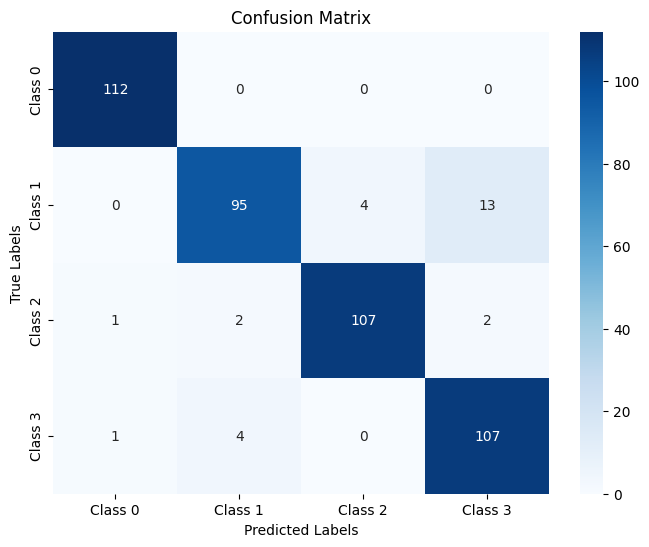

In [36]:
# Predict on the test data
y_pred = model.predict(X_test_reshaped)

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [43]:
# Extract class names from the training data generator
class_indices = train_data_gen.class_indices  # This gives a dictionary mapping class names to indices
class_names = [key for key, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Class Names:", class_names)


Class Names: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']
